In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import matplotlib.pylab as plt

In [7]:
train=pd.read_csv('../data/train.csv')
test=pd.read_csv('../data/test.csv')
# combine test dataset and train dataset
df =pd.concat([train, test], axis=0)

In [8]:
df_no_unknown = df[(df['job'] != 'unknown') & (df['education'] != 'unknown') & (df['marital'] != 'unknown') & (df['default'] != 'unknown') & (df['housing'] != 'unknown') & (df['loan'] != 'unknown')]

In [12]:
features_list = ['job', 'education', 'marital', 'default', 'housing', 'loan']

In [20]:
one_hot_df = df_no_unknown[['id', 'age']].reset_index()
for feature in features_list:
    encoder = OneHotEncoder(sparse_output=False)
    feature_df = pd.DataFrame(encoder.fit_transform(df_no_unknown[[feature]]),
                              columns=encoder.get_feature_names_out([feature]))
    one_hot_df = pd.concat([one_hot_df, feature_df], axis=1)
one_hot_df

,index,id,age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,education_university.degree,marital_divorced,marital_married,marital_single,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes
0,0,1,51,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,2,3,48,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3,4,26,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,4,5,45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,6,7,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21367,7493,29994,41,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
21368,7496,29997,34,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
21369,7497,29998,50,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
21370,7498,29999,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


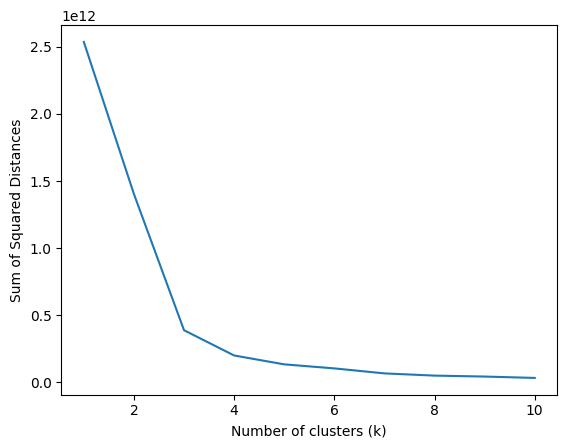

In [21]:
inertia = []
for nc in range(1,11):
    kmeans = KMeans(n_clusters=nc, random_state=0).fit(one_hot_df)
    inertia.append(kmeans.inertia_)
interias = pd.DataFrame({'n_clusters': range(1, 11), 'inertia': inertia})

plot = interias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances')
plot.legend().set_visible(False)
plt.show()

In [22]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(one_hot_df)
memb = pd.DataFrame(kmeans.labels_, one_hot_df.index, columns=['Cluster'])
utilities_memb = pd.concat([one_hot_df, memb], axis=1)
utilities_memb

,index,id,age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,marital_divorced,marital_married,marital_single,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,Cluster
0,0,1,51,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1
1,2,3,48,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1
2,3,4,26,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1
3,4,5,45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1
4,6,7,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21367,7493,29994,41,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2
21368,7496,29997,34,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2
21369,7497,29998,50,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2
21370,7498,29999,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2
